<a href="https://colab.research.google.com/github/AtriSaxena/Tensorflow-2.X-Zero2Mastery/blob/main/04_transfer_learning_part01_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part1: Feature Extraction 

Transfer learning is leveraging a working models existing architecture and learned patterns for our own problem. 

There are tow main benefits: 
1. Can leverage an existing neural network architecture proven to work on the problems similar to our own. 
2. Can leverage a working neural network which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data. 

In [ ]:

!nvidia-smi

Sun Nov 14 15:50:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading and become one with data

In [ ]:
#Download the data (10% of 10 food classes from Food101)

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

import zipfile 

#unzip the file 

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall() 
zip_ref.close()

--2021-11-14 15:50:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  83.1MB/s    in 1.9s    

2021-11-14 15:50:39 (83.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#How many images in each folder 
import os 

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"): 
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

# Create data loaders(preparing the data) 

We will use the `ImageDataGenerators` class to load in our images in batches. 

In [ ]:
#Setup data inputs 

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

IMAGE_SHAPE = (224,224) 
BATCH_SIZE = 32 

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/" 

train_datagen = ImageDataGenerator(rescale=1/255.) 
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training Images: ")

train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          batch_size = BATCH_SIZE, 
                                                          target_size = IMAGE_SHAPE,
                                                          class_mode = "categorical")

print("Test Images:")

test_data_10_percent = train_datagen.flow_from_directory(test_dir, 
                                                         batch_size = BATCH_SIZE, 
                                                          target_size = IMAGE_SHAPE,
                                                          class_mode = "categorical")

Training Images: 
Found 750 images belonging to 10 classes.
Test Images:
Found 2500 images belonging to 10 classes.


## Setting back callbacks 

* Tracking experiment with the Tensorboard callbacks. 
* Model checkpoint with the ModelCheckpoint callbacks. 
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.

`tf.keras.callbacks.Callback`

In [ ]:
#Create Tensorflow callbacks (Functionized because we need to create a new one for each model) 

import datetime 

def create_tensorboard_callback(dir_name, experiment_name): 
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback


## Creating models using Tensorflow hub 

Tensorflow hub contains the pretrained models on certain data. 

We can access the pretrained models on https://tfhub.dev  

From various models we found two models for our problem: 
1. EfficientNet: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

2. Resnet50: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

EfficientNet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
#Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras import layers 

In [ ]:
#Let's  make a create_model() function to create a model from a URL 

def create_model(model_url, num_classes=10): 
  """
  Takes a Tensorflow hub URL and creates a keras Sequential model with it

  Args:  
    model_url (str): A Tensorflow Hub feature extraction URL. 
    num_classes(int): Number of output neurons in the output layer, should be 
      equal to number of targer classes, default 10. 
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer
    and Dense output layer with num_classes output neurons.  
  """

  #Download the pretrained model and save it as a Keras layer 
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable = False, 
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,))
  
  #create our own model 
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation = "softmax", name ="output_layer")
  ])

  return model


## Creating and testing ResNet Tensorflow Hub Feature extraction model 



In [ ]:
#Create resnet model 

resnet_model = create_model(resnet_url, 
                              num_classes = train_data_10_percent.num_classes)

In [ ]:
#Compile our resnet model
resnet_model.compile(loss= "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics=["accuracy"]) 


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#Let's fit our Resnet model to the data (10 percent of 10 classes)

resnet_history = resnet_model.fit(train_data_10_percent, 
                                      epochs=5, 
                                      steps_per_epoch = len(train_data_10_percent),
                                      validation_data= test_data_10_percent, 
                                      validation_steps = len(test_data_10_percent),
                                      callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", 
                                                                               experiment_name = "resnet50V2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20211114-155056
Epoch 1/5
24/24 [==============================] - 59s 1s/step - loss: 1.8389 - accuracy: 0.3987 - val_loss: 1.1334 - val_accuracy: 0.6372
Epoch 2/5
24/24 [==============================] - 22s 940ms/step - loss: 0.8592 - accuracy: 0.7627 - val_loss: 0.8035 - val_accuracy: 0.7484
Epoch 3/5
24/24 [==============================] - 22s 927ms/step - loss: 0.5970 - accuracy: 0.8387 - val_loss: 0.7327 - val_accuracy: 0.7720
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.4640 - accuracy: 0.8787 - val_loss: 0.6788 - val_accuracy: 0.7820
Epoch 5/5
24/24 [==============================] - 22s 930ms/step - loss: 0.3682 - accuracy: 0.9067 - val_loss: 0.6582 - val_accuracy: 0.7840


That is incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built and in quicker training time and 10 % of training time.

In [ ]:
#Lets create a function to plot our loss curves. 
# Tidbit: you could put a function like this into a script called 'helper.py' and import it when you need it. 

import matplotlib.pyplot as plt 

#Plot the training and validation curves 
def plot_loss_curves(history): 
  """
  Returns seperate loss curves for training and validation metrics. 

  Args: 
    history: Tensorflow history object 

  Returns: 
    Plots of training/validation loss and accuracy metrics. 
  """ 

  #loss
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  #Accuracy
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"] 

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


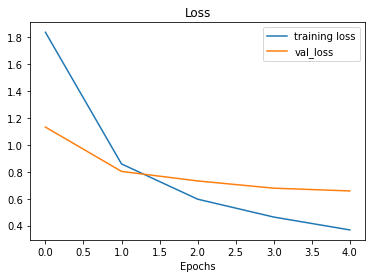

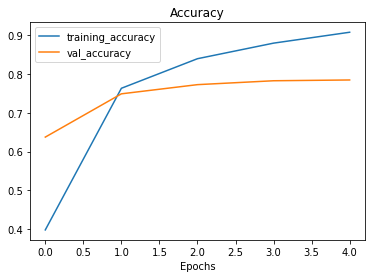

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientB0 Tensorflow Hub Feature extraction model 



In [ ]:
#Create efficientB0 feature extractor model
efficientnet_model = create_model(EfficientNet_url, num_classes=10)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
#Compile our efficient model
efficientnet_model.compile(loss= "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics=["accuracy"]) 

In [ ]:
#Let's fit our efficient model to the data (10 percent of 10 classes)

efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                      epochs=5, 
                                      steps_per_epoch = len(train_data_10_percent),
                                      validation_data= test_data_10_percent, 
                                      validation_steps = len(test_data_10_percent),
                                      callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", 
                                                                               experiment_name = "efficientnetb0")])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20211114-155903
Epoch 1/5
24/24 [==============================] - 34s 918ms/step - loss: 1.8439 - accuracy: 0.4333 - val_loss: 1.3195 - val_accuracy: 0.7156
Epoch 2/5
24/24 [==============================] - 19s 832ms/step - loss: 1.0689 - accuracy: 0.7867 - val_loss: 0.8864 - val_accuracy: 0.8088
Epoch 3/5
24/24 [==============================] - 19s 826ms/step - loss: 0.7650 - accuracy: 0.8427 - val_loss: 0.7093 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 19s 825ms/step - loss: 0.6145 - accuracy: 0.8707 - val_loss: 0.6211 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 19s 827ms/step - loss: 0.5209 - accuracy: 0.8867 - val_loss: 0.5668 - val_accuracy: 0.8560


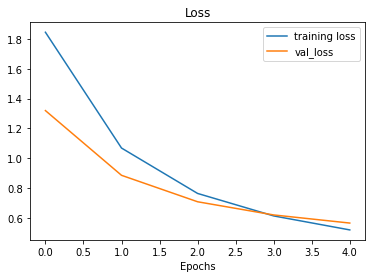

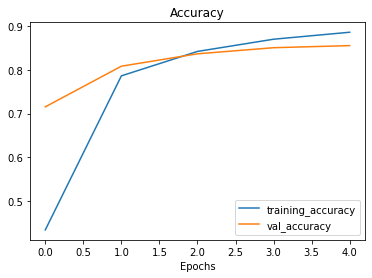

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning 

* **"As is" transfer learning** using an existing model with no changes what so ever (e.g., using ImagenetModel on 1000 Imagenet classes, none of our own.) 

* **"Feature extraction"** transfer learning- use the prelearned patterns of an existing model(e.g EfficientNet trained on Imagenet) and adjust the output layers only for our own problem( e.g changing 1000 classes to -> 10 classes) 

* **"Fine tuning" transfer learning** - use the prelearned patterns of an existing model and "fine tine" ,many or all of the underlying layers(including new output layer) 

## Comparing our models results using Tensorboard 


In [ ]:
#Upload to tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \ 
--name "EfficientNetB0 vs Resnet50V2" \
-- description "analysis of model" \
--one_shot 

SyntaxError: ignored

In [ ]:
#Delete an experiment:
# !tensorboard dev delete --experiement id some_id 
 

In [ ]:
#confirm the deletion by re-checking what experiments you have left
!tensorboard dev list